In [35]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mayavi import mlab
from numba import jit
from tvtk.tools import visual
#from skimage.feature import peak_local_max
from scipy import interpolate
import math
from numpy import unravel_index

In [36]:
#the angle between the rotation axis and the observer 
delta = 79*np.pi/180.0

T = 50
omega = 2*np.pi/T

R = 1e6
r_em = 100*R

N1 = 100
N2 = 100
N3 = 100

w=250*R
xa = np.linspace(-w,w,N1)
ya = np.linspace(-w,w,N2)
za = np.linspace(-w,w,N3)
center = int(N1/2.0)

px = 0.0
py = 0.985
pz = 0.174

In [37]:
#the angle between the magnetic moment axis and the observer
alpha = 80*np.pi/180.0

#the angle between the rotation axis and the observer 
delta = 79*np.pi/180.0

@jit(parallel=True)
def cal_m(phi):
    phi = phi+np.pi/2.0
    m_x = np.sin(alpha)*np.cos(delta)*np.cos(phi)-np.sin(delta)*np.cos(alpha)
    m_y = np.sin(alpha)*np.sin(phi)
    m_z = np.cos(alpha)*np.cos(delta) + np.sin(alpha)*np.sin(delta)*np.cos(phi)
    return m_x,m_y,m_z
  
@jit(parallel=True)
def cal_bfield(phi_new, th_em, phi_em, r_em, h):
    x_ray = r_em*np.sin(th_em)*np.cos(phi_em)
    y_ray = r_em*np.sin(th_em)*np.sin(phi_em)
    z_ray = r_em*np.cos(th_em) + h
    m_x, m_y, m_z = cal_m(phi_new)
    r = np.sqrt(x_ray**2 + y_ray**2 + z_ray**2)
    B_y = (-m_y/r**3 + 3*y_ray*(m_x*x_ray + m_y*y_ray + m_z*z_ray)/r**5)
    B_x = (-m_x/r**3 + 3*x_ray*(m_x*x_ray + m_y*y_ray + m_z*z_ray)/r**5)
    B_z = (-m_z/r**3 + 3*z_ray*(m_x*x_ray + m_y*y_ray + m_z*z_ray)/r**5)
    Bmag = np.sqrt(B_x**2+B_y**2+B_z**2)
    return B_x/Bmag, B_y/Bmag

@jit(parallel=True)
def get_emission_point_dip(m_x,m_y,m_z):
    th_em = np.arccos(m_z)/2.0 - 0.5*np.arcsin(0.33*np.sin(np.arccos(m_z)))
    phi_em = np.arctan(m_y/m_x)
    #print (th_em*180/np.pi, phi_em*180/np.pi)
    return th_em, phi_em

@jit(parallel=True)
def get_bfield(x,y,z,phi):
    m_x, m_y, m_z = cal_m(phi)
    r = np.sqrt(x**2 + y**2 + z**2)
    B_y = (-m_y/r**3 + 3*y*(m_x*x + m_y*y + m_z*z)/r**5)
    B_x = (-m_x/r**3 + 3*x*(m_x*x + m_y*y + m_z*z)/r**5)
    B_z = (-m_z/r**3 + 3*z*(m_x*x + m_y*y + m_z*z)/r**5)
    Bmag = np.sqrt(B_x**2+B_y**2+B_z**2)
    return B_x/Bmag, B_y/Bmag, B_z/Bmag

@jit(parallel=True)
def get_field(x0,y0,z0,t):
    x = np.cos(omega*t)*(x0*np.cos(delta) + z0*np.sin(delta))+np.sin(omega*t)*y0
    y = -np.sin(omega*t)*(np.cos(delta)*x0 + np.sin(delta)*z0)+ np.cos(omega*t)*y0
    z = -x0*np.sin(delta) + z0*np.cos(delta)
    r1 = np.sqrt(x**2+y**2+z**2)
    r2 = np.sqrt(x**2+y**2+(z-0.4*R)**2)
    rqrt = 0.6*x**2 + y*(-0.8*y-2*(z-0.4*R)) + (z-0.4*R)*(-2*y+0.2*(z-0.4*R))
    #rqrt = 0.6*x**2 + y*(-0.8*y-2*(z+0.4)) + (z+0.4)*(-2*y+0.2*(z+0.4))
    bxd = -px/r1**3 + 3*(px*x+py*y+pz*z)*x/r1**5
    byd = -py/r1**3 + 3*(px*x+py*y+pz*z)*y/r1**5
    bzd = -pz/r1**3 + 3*(px*x+py*y+pz*z)*z/r1**5
    bxq = -2*0.6*x/r2**5 + 5.0*(rqrt)*x/r2**7
    byq = -2*(-0.8*y-2*(z-0.4*R))/r2**5 + 5.0*(rqrt)*y/r2**7
    bzq = -2*(-2*y+0.2*(z-0.4*R))/r2**5 + 5.0*(rqrt)*(z-0.4*R)/r2**7
    bx = bxd
    by = byd
    bz = bzd
    Bx = np.cos(delta)*np.cos(omega*t)*bx - np.cos(delta)*np.sin(omega*t)*by-np.sin(delta)*bz
    By = np.sin(omega*t)*bx + np.cos(omega*t)*by
    Bz = np.sin(delta)*np.cos(omega*t)*bx - np.sin(delta)*np.sin(omega*t)*by + np.cos(delta)*bz
    Bmag = np.sqrt(Bx**2+By**2+Bz**2)
    return Bx/Bmag, By/Bmag, Bz/Bmag


@jit(parallel=True)
def cal_PA_dip(h,r_em,T,ax):
    c = 3e10
    t_ray = h*1e3/c
    t = 0.0
    dt = 0.1
    Rl = c*T*1e-3/2/np.pi
    PA, phase = [],[]
    phi = 0
    while phi<2*np.pi:
        phi = omega*t
        m_x, m_y, m_z = cal_m(phi)
        th_em, phi_em = get_emission_point_dip(m_x,m_y,m_z)
        B_x, B_y = cal_bfield(phi + 2*np.pi*t_ray/T, th_em, phi_em, r_em, h)
        Psi = np.arctan(B_y/B_x)
        PA.append(Psi)
        phase.append(phi)
        t += dt
    PA = np.array(PA)*180/np.pi
    phase = np.array(phase)*180/np.pi
    ax.plot(phase,PA,label=r"h="+str(round(h*1e-5))+" km")

In [38]:
@jit(parallel=True)
def compute_total_field(t):
    b1 = np.zeros((N1,N2,N3))
    b2 = np.zeros((N1,N2,N3))
    b3 = np.zeros((N1,N2,N3))
    for i in range(N1):
        for j in range(N2):
            for k in range(N3):
                bv1,bv2,bv3 = get_field(xa[i],ya[j],za[k],t)
                if (xa[i]**2+ya[j]**2+za[k]**2>1):
                    b1[i][j][k] = bv1
                    b2[i][j][k] = bv2
                    b3[i][j][k] = bv3
    bmag = np.sqrt(b1**2+b2**2+b3**2)
    return b1,b2,b3

In [39]:
@jit(parallel=True)
def get_emission_point(t):
    thetas = np.linspace(0,np.pi,200)
    phis = np.linspace(0,2*np.pi,200)
    xsurf = np.zeros((len(thetas),len(phis))) 
    ysurf = np.zeros((len(thetas),len(phis)))
    zsurf = np.zeros((len(thetas),len(phis)))
    Bsurf = np.zeros((len(thetas),len(phis)))
    for i in range(len(thetas)):
        for j in range(len(phis)):
            xsurf[i][j] = r_em*np.sin(thetas[i])*np.cos(phis[j])
            ysurf[i][j] = r_em*np.sin(thetas[i])*np.sin(phis[j])
            zsurf[i][j] = r_em*np.cos(thetas[i])
            bx_s,by_s,bz_s = get_field(xsurf[i][j],ysurf[i][j],zsurf[i][j],t)
            if bz_s>0 and zsurf[i][j]>0:
                Bsurf[i][j] = bz_s            
    m = unravel_index(Bsurf.argmax(), Bsurf.shape)
    mx = m[0]
    my = m[1]
    xx = xsurf[mx][my]
    yy = ysurf[mx][my]
    zz = zsurf[mx][my]
    return xx,yy,zz

In [40]:
@jit(parallel=True)
def get_emission_point2(t,new_thetas,new_phis):
    xsurf2 = np.zeros((len(new_thetas),len(new_phis)))
    ysurf2 = np.zeros((len(new_thetas),len(new_phis)))
    zsurf2 = np.zeros((len(new_thetas),len(new_phis)))
    Bsurf2 = np.zeros((len(new_thetas),len(new_phis)))
    for i in range(len(new_thetas)):
        for j in range(len(new_phis)):
            xsurf2[i][j] = r_em*np.sin(new_thetas[i])*np.cos(new_phis[j])
            ysurf2[i][j] = r_em*np.sin(new_thetas[i])*np.sin(new_phis[j])
            zsurf2[i][j] = r_em*np.cos(new_thetas[i])      
            bx_s2,by_s2,bz_s2 = get_field(xsurf2[i][j],ysurf2[i][j],zsurf2[i][j],t)
            Bsurf2[i][j] = bz_s2
    m2 = unravel_index(Bsurf2.argmax(), Bsurf2.shape)
    mx2 = m2[0]
    my2 = m2[1]
    xx2 = xsurf2[mx2][my2]
    yy2 = ysurf2[mx2][my2]
    zz2 = zsurf2[mx2][my2]
    return xx2,yy2,zz2

In [41]:
@jit(parallel=True)
def get_emission_point_final(t):
    p1,p2,p3 = get_emission_point(t)
    phi_p =  np.arctan2(p2,p1)*180/np.pi
    th_p = np.arccos(p3/np.sqrt(p1**2+p2**2+p3**2))*180/np.pi
    max_th_p, min_th_p = math.ceil(th_p),math.floor(th_p)
    max_phi_p, min_phi_p = math.ceil(phi_p),math.floor(phi_p)
    newth = np.linspace(-1+min_th_p,max_th_p+1,400)*np.pi/180
    newphi = np.linspace(-1+min_phi_p,max_phi_p+1,400)*np.pi/180
    #print (newphi*180/np.pi)
    nx,ny,nz = get_emission_point2(t,newth,newphi)
    return nx,ny,nz

In [42]:
p1,p2,p3 = get_emission_point_final(0)
print (p1,p2,p3)
print (np.arctan2(p2,p1)*180/np.pi)
print (np.arccos(p3/np.sqrt(p1**2+p2**2+p3**2))*180/np.pi)

/var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_28574/975182961.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_emission_point_final" failed type inference due to: Invalid use of type(CPUDispatcher(<function get_emission_point at 0x144942f70>)) with parameters (int64)

During: resolving callee type: type(CPUDispatcher(<function get_emission_point at 0x144942f70>))
During: typing of call at /var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_28574/975182961.py (3)


File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_28574/975182961.py", line 3:
<source missing, REPL/exec in use?>

  @jit(parallel=True)
/Users/asur/myenv3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "get_emission_point_final" was compiled in object mode without forceobj=True.

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_28574/975182961.py", l

-9629155.721669467 55546930.636953376 82594296.75771402
99.8345864661654
34.31578947368422


/Users/asur/myenv3/lib/python3.8/site-packages/numba/core/typed_passes.py:331: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_28574/1231278314.py", line 7:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


In [43]:
def drawSphereMlab(center, radius, **kwargs):
    xc, yc, zc = center
    phi, theta = np.mgrid[0:np.pi:101j, 0:2*np.pi:101j]
    x = xc + radius * np.sin(phi) * np.cos(theta)
    y = yc + radius * np.sin(phi) * np.sin(theta)
    z = zc + radius * np.cos(phi)
    sphere = mlab.mesh(x, y, z, **kwargs)
    return sphere

In [44]:
@jit(parallel=True)
def cal_newbfield(xem,yem,zem,h,time):
    x_ray = xem
    y_ray = yem
    z_ray = zem + h
    B_x,B_y,B_z = get_field(x_ray,y_ray,z_ray,time)
    return B_x, B_y

In [45]:
@jit(parallel=True)
def cal_PA(h,T,ax,color,lb):
    c = 3e10
    t_ray = h*1e3/c
    t = 0
    dt = 0.5
    Rl = c*T*1e-3/2/np.pi
    PA, phase = [],[]
    phi = 0
    while phi<2*np.pi:
        phi = omega*(t)
        #print (t, phi*180/np.pi)
        xem,yem,zem = get_emission_point_final(t)
        B_x, B_y = cal_newbfield(xem,yem,zem,h,t+t_ray)
        Psi = np.arctan(B_y/B_x)
        PA.append(Psi)
        phase.append(phi)
        t = t+dt
    PA = np.array(PA)*180/np.pi
    phase = np.array(phase)*180/np.pi
    ax.scatter(phase,PA,s=20,c=color,alpha=0.8,label="r_em = "+str(lb/R)+"R")
    #ax.plot(phase,PA)

/var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_28574/436416382.py:70: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cal_PA_dip" failed type inference due to: non-precise type pyobject
During: typing of argument at /var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_28574/436416382.py (72)

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_28574/436416382.py", line 72:
<source missing, REPL/exec in use?>

  @jit(parallel=True)
/Users/asur/myenv3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "cal_PA_dip" was compiled in object mode without forceobj=True.

File "../../../../var/folders/4c/p1r_3jbn20jbtyp11b8_7y140001sh/T/ipykernel_28574/436416382.py", line 70:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/Users/asur/myenv3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning

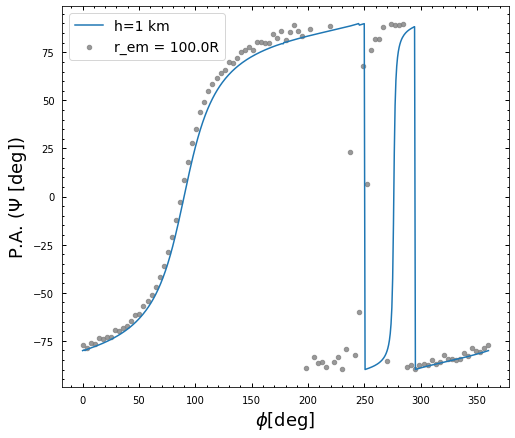

In [46]:
f = plt.figure(figsize=(8,7))
ax = f.add_subplot(111)
cal_PA_dip(1e5,r_em, T, ax)
cal_PA(1e5, T, ax, 'gray',r_em)
ax.set_xlabel(r'$\phi$[deg]',size=18)
ax.set_ylabel(r'P.A. ($\Psi$ [deg])',size=18)
ax.legend(loc="best",fontsize=14,ncol=1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis="x", labelsize=18) 
ax.tick_params(axis="y", labelsize=18)
ax.tick_params(axis='both', which='major', direction='in',labelsize=10, length=4, width=1., colors='k', left=True, right=True, top=True, pad=8)
ax.tick_params(axis='both', which='minor', direction='in',labelsize=10, length=2, width=1, colors='k', left=True, right=True, top=True, pad=8)
#plt.savefig("PA_quad_dip.png",bbox_inches='tight')
plt.show()